7/7 [==============================] - 0s 2ms/step


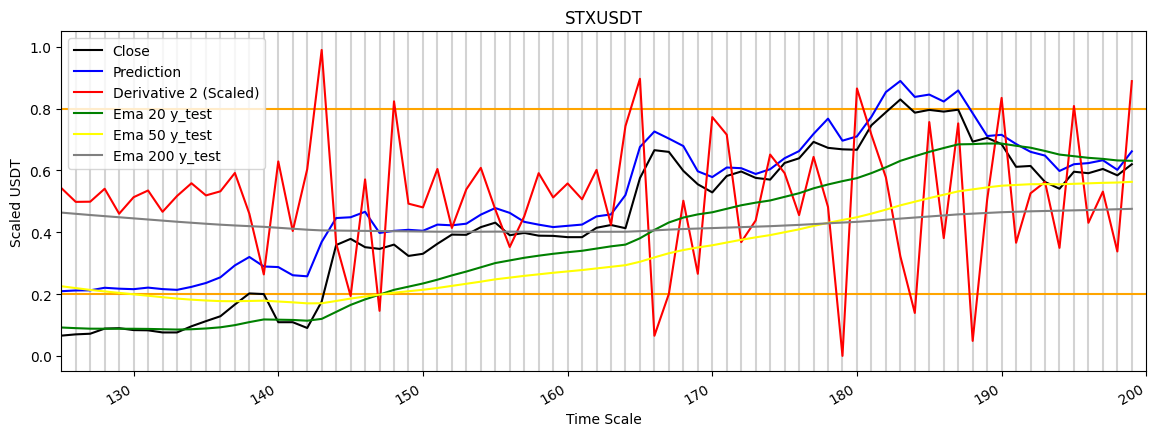

C:\Users\Luis Gomez Freites\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
C:\Users\Luis Gomez Freites\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Luis Gomez Freites\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only ac

Start                     2023-06-03 14:00:00
End                       2023-06-07 17:30:00
Duration                      4 days 03:30:00
Exposure Time [%]                         0.5
Equity Final [$]                  1015.719412
Equity Peak [$]                   1015.719412
Return [%]                           1.571941
Buy & Hold Return [%]                1.698205
Return (Ann.) [%]                  212.236695
Volatility (Ann.) [%]               30.383819
Sharpe Ratio                         6.985188
Sortino Ratio                             inf
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       0.889256
Worst Trade [%]                      0.889256
Avg. Trade [%]                    

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import constantes as cons
import keras 
import datetime as dt
import pandas_ta as ta

symbol =  str.upper('stx'+'USDT')
client = cons.client

umbralbajo=0.2
umbralalto=0.8

# esta funcion solo la uso en el notebook ya que en el programa se hace con pandas_ta
def ema (signal,N=10):
    k = 2 / (N + 1)  # Factor de suavizado
    ema = np.zeros_like(signal)  # Array para almacenar los valores de la EMA
    ema[0] = signal[0]  # El primer valor de la EMA es igual al primer valor de deriv_y_pred_scaled2
    for i in range(1, len(signal)):
        ema[i] = (signal[i] * k) + (ema[i-1] * (1 - k))
    return ema
#######################################################################################

timeframe='30m'
historical_data = client.get_historical_klines(symbol, timeframe)
data = pd.DataFrame(historical_data)
data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                    'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
data['Open Time'] = pd.to_datetime(data['Open Time']/1000, unit='s')
data['Close Time'] = pd.to_datetime(data['Close Time']/1000, unit='s')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, axis=1)
data['timestamp']=data['Open Time']
data.set_index('timestamp', inplace=True)

data.dropna(inplace=True)
data.drop(['Open Time','Close Time','Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume','Number of Trades',
          'Ignore'], axis=1, inplace=True)
stock_data = data
pd.set_option('display.max_columns', None)

############################################################################################

X_feat = stock_data.iloc[:,0:3]

X_ft = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns,data=X_ft,index=X_feat.index)

def ltsm_split (data,n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps+1):
        X.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps-1, -1])
    return np.array(X),np.array(y)

n_steps=1
X1, y1 = ltsm_split(X_ft.values, n_steps=n_steps)

train_split =0.8
split_idx = int(np.ceil(len(X1)*train_split))

X_train , X_test = X1[:split_idx], X1[split_idx:]
y_train , y_test = y1[:split_idx], y1[split_idx:]

lstm=Sequential()
lstm.add(LSTM(32,input_shape=(X_train.shape[1],X_train.shape[2]),activation='relu',return_sequences=True))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error',optimizer='adam')

#lstm.fit(X_train,y_train,epochs=20,batch_size=4,verbose=2,shuffle=False)
lstm = keras.models.load_model('modelos/lstm'+symbol+'.h5')

# señales para la grafica
y_pred = lstm.predict(X_test)
# Calcular las derivadas
deriv_y_pred = np.diff(y_pred, axis=0)
deriv_y_pred2 = np.diff(deriv_y_pred, axis=0)
# Ajustar la forma de deriv_y_pred
deriv_y_pred = deriv_y_pred.reshape(-1, 1)
deriv_y_pred2 = deriv_y_pred2.reshape(-1, 1)
# Escalar las derivadas
scaler1 = MinMaxScaler(feature_range=(0, 1))
deriv_y_pred_scaled = scaler1.fit_transform(deriv_y_pred)
scaler2 = MinMaxScaler(feature_range=(0, 1))
deriv_y_pred_scaled2 = scaler2.fit_transform(deriv_y_pred2)
deriv_y_pred_scaled = np.insert(deriv_y_pred_scaled, 0, deriv_y_pred_scaled[0], axis=0)#para mover 1 posicion hacia adelante
deriv_y_pred_scaled2 = np.insert(deriv_y_pred_scaled2, 0, deriv_y_pred_scaled2[0], axis=0)#para mover 1 posicion hacia adelante
deriv_y_pred_scaled2 = np.insert(deriv_y_pred_scaled2, 0, deriv_y_pred_scaled2[0], axis=0)#para mover 1 posicion hacia adelante

ema_deriv=ema(deriv_y_pred_scaled)
ema_deriv = MinMaxScaler(feature_range=(0, 1)).fit_transform(ema_deriv)
ema_deriv2=ema(deriv_y_pred_scaled2,50)
ema_deriv2 = MinMaxScaler(feature_range=(0, 1)).fit_transform(ema_deriv2)
ema_y_test_20=ema(y_test,20)
ema_y_test_50=ema(y_test,50)
ema_y_test_200=ema(y_test,200)

#grafica

plt.figure(figsize=(14, 5))
time_index = range(n_steps-1, n_steps-1+len(y_pred))
# Agregar líneas verticales
for i in time_index:
    plt.axvline(x=i, color='lightgray')
plt.xlim(0,len(y_test))
plt.axhline(y = umbralalto, color = 'orange', linestyle = '-')
#plt.axhline(y = 0.5, color = 'GREY', linestyle = '-')
plt.axhline(y = umbralbajo, color = 'orange', linestyle = '-')
plt.plot(y_test, label='Close',color = 'black')

plt.plot( y_pred[:, -1, 0], label='Prediction',color = 'blue')
#plt.plot(deriv_y_pred_scaled, label='Derivative 1 (Scaled)',color = 'blue')
plt.plot( deriv_y_pred_scaled2, label='Derivative 2 (Scaled)', color='red')
#plt.plot( ema_deriv, label='Ema Derivative 1 (Scaled)', color='green')
#plt.plot( ema_deriv2, label='Ema Derivative 2 (Scaled)', color='orange')

plt.plot( ema_y_test_20, label='Ema 20 y_test', color='green')
plt.plot( ema_y_test_50, label='Ema 50 y_test', color='yellow')
plt.plot( ema_y_test_200, label='Ema 200 y_test', color='grey')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USDT')
plt.legend()
plt.gcf().autofmt_xdate()
plt.title(symbol)
#plt.grid()
plt.show()

data['ema20']=data.ta.ema(20)
data['ema50']=data.ta.ema(50)
data['ema200']=data.ta.ema(200)
data['atr']=ta.atr(data.High, data.Low, data.Close)
data=data.tail(200)
data_copy = data.copy()
data_copy['deriv'] = deriv_y_pred_scaled2
data=data_copy

from backtesting import Backtest, Strategy

class Predictor2(Strategy):
    def init(self):
        pass

    def next(self):
        if self.position:
            pass
        else:
            if self.data.Close[-1] > self.data.ema20[-1] > self.data.ema50[-1] > self.data.ema200[-1] and self.data.deriv[-1] >= umbralalto and self.data.deriv[-2] > umbralbajo:
                self.buy(size=1000, sl=self.data.ema200[-1] , tp=self.data.Close[-1] + self.data.atr[-1])
            elif self.data.Close[-1] < self.data.ema20[-1] < self.data.ema50[-1] < self.data.ema200[-1] and self.data.deriv[-1] <= umbralbajo and self.data.deriv[-2] < umbralalto:
                self.sell(size=1000, sl=self.data.ema200[-1] , tp=self.data.Close[-1] - self.data.atr[-1])

bt = Backtest(data, Predictor2,
              cash=1000, commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot()
output
